In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
import xgboost as xgb
from numpy import random, transpose
import re, string
random.seed(156)
%matplotlib inline

# Importation des données

In [116]:
movies = pd.read_csv("movies.csv", index_col=0)

## Nettoyage des données

In [117]:
movies = movies.loc[movies.review != 0]
movies

,imdb_id,original_title,title,rating,production_budget,marketing_budget,duration,release_date,is3d,synopsis,review
id,,,,,,,,,,,
332,tt4520988,Frozen II,Frozen II,NaN,NaN,NaN,NaN,2019-11-20,NaN,"Elsa, Anna, Kristoff and Olaf head far into th...",7.1
333,tt1302006,The Irishman,The Irishman,NaN,NaN,NaN,NaN,2019-11-01,NaN,"Pennsylvania, 1956. Frank Sheeran, a war veter...",8.2
334,tt7498092,Ellipse,Ellipse,NaN,NaN,NaN,NaN,2019-11-05,NaN,"A man and his dog are stranded on a volatile, ...",3.5
335,tt6450804,Terminator: Dark Fate,Terminator: Dark Fate,NaN,NaN,NaN,NaN,2019-10-23,NaN,Decades after Sarah Connor prevented Judgment ...,6.2
336,tt7286456,Joker,Joker,NaN,NaN,NaN,NaN,2019-10-02,NaN,"During the 1980s, a failed stand-up comedian i...",8.4
...,...,...,...,...,...,...,...,...,...,...,...
11861,tt9290986,The Infinity Project,The Infinity Project,NaN,NaN,NaN,NaN,2018-11-30,NaN,When the American ambassador to Italy is kidna...,1.0
11862,tt8426876,Lucha VaVoom: Inside America’s Most Outrageous...,Lucha VaVoom: Inside America’s Most Outrageous...,NaN,NaN,NaN,NaN,2018-10-16,NaN,Lucha VaVoom: Inside America’s Most Outrageous...,1.0
11863,tt5158800,God Made Man,God Made Man,NaN,NaN,NaN,NaN,2018-12-25,NaN,"Leading double lives and seeking redemption, a...",1.0


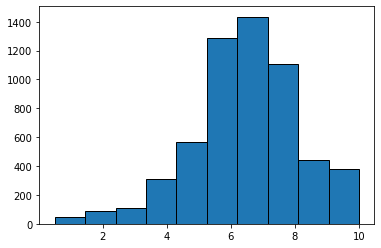

In [118]:
plt.hist(movies.review, edgecolor='black');

In [119]:
movies.release_date = pd.to_datetime(movies.release_date, format='%Y-%m-%d')

In [120]:
movies.dtypes

imdb_id                      object
original_title               object
title                        object
rating                      float64
production_budget           float64
marketing_budget            float64
duration                    float64
release_date         datetime64[ns]
is3d                        float64
synopsis                     object
review                      float64
dtype: object

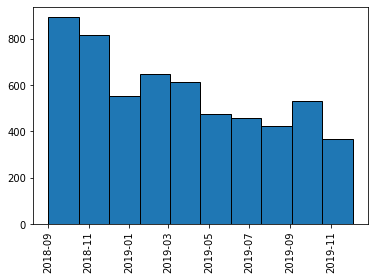

In [121]:
plt.hist(movies.release_date, edgecolor='black');
plt.xticks(rotation='vertical');

# Préparation des données

In [122]:
X_trainfull = movies[['original_title']]
Y_trainfull = movies.review

## Séparation des données en ensembles d'entraînement et de validation

In [123]:
X_train, x_val, Y_train, y_val = train_test_split(X_trainfull, Y_trainfull, test_size=0.1, random_state=156)
Y_train = transpose([Y_train])
y_val = transpose([y_val])
print(X_train.shape, Y_train.shape, x_val.shape, y_val.shape)
X_train

(5201, 1) (5201, 1) (578, 1) (578, 1)


,original_title
id,
2524,Loners
6452,Oru Yamandan Premakadha
9608,Blue
5683,PSYCHO-PASS サイコパス Sinners of the System Case.1...
944,The Laundromat
...,...
9036,"Pride, Prejudice and Mistletoe"
4036,Die Bestatterin - Der Tod zahlt alle Schulden
6536,Red Room


## Découpage du titre en mots

In [124]:
word_number = 0
for index, row in X_train.iterrows():
    title = str(X_train.loc[index, 'original_title']).lower()
    title = title.translate(title.maketrans("","", string.punctuation))
    title_split = title.split()
    i = 1
    for word in title_split:
        if len(word) >= 4:          
            i += 1
    
    if i > word_number:
        word_number = i

print(word_number)

11


In [125]:
X_train.insert(len(X_train.columns), 'nb_mots', 0)

for i in range(1, word_number+1):
    X_train.insert(len(X_train.columns), f'mot {i}', None)

X_train

,original_title,nb_mots,mot 1,mot 2,mot 3,mot 4,mot 5,mot 6,mot 7,mot 8,mot 9,mot 10,mot 11
id,,,,,,,,,,,,,
2524,Loners,0,None,None,None,None,None,None,None,None,None,None,None
6452,Oru Yamandan Premakadha,0,None,None,None,None,None,None,None,None,None,None,None
9608,Blue,0,None,None,None,None,None,None,None,None,None,None,None
5683,PSYCHO-PASS サイコパス Sinners of the System Case.1...,0,None,None,None,None,None,None,None,None,None,None,None
944,The Laundromat,0,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9036,"Pride, Prejudice and Mistletoe",0,None,None,None,None,None,None,None,None,None,None,None
4036,Die Bestatterin - Der Tod zahlt alle Schulden,0,None,None,None,None,None,None,None,None,None,None,None
6536,Red Room,0,None,None,None,None,None,None,None,None,None,None,None


In [126]:
word_number = 0
for index, row in X_train.iterrows():
    title = str(X_train.loc[index, 'original_title']).lower()
    title = title.translate(title.maketrans("","", string.punctuation))
    title_split = title.split()
    i = 1
    for word in title_split:
        if len(word) >= 4:          
            X_train.loc[index, f'mot {i}'] = word
            i += 1
    
    X_train.loc[index, 'nb_mots'] = i - 1

del X_train['original_title']
X_train

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,nb_mots,mot 1,mot 2,mot 3,mot 4,mot 5,mot 6,mot 7,mot 8,mot 9,mot 10,mot 11
id,,,,,,,,,,,,
2524,1,loners,None,None,None,None,None,None,None,None,None,None
6452,2,yamandan,premakadha,None,None,None,None,None,None,None,None,None
9608,1,blue,None,None,None,None,None,None,None,None,None,None
5683,5,psychopass,サイコパス,sinners,system,case1「罪と罰」,None,None,None,None,None,None
944,1,laundromat,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
9036,3,pride,prejudice,mistletoe,None,None,None,None,None,None,None,None
4036,4,bestatterin,zahlt,alle,schulden,None,None,None,None,None,None,None
6536,1,room,None,None,None,None,None,None,None,None,None,None


## Création d'une colonne pour chaque mot apparaissant dans les titres

In [127]:
X_train = pd.get_dummies(X_train, prefix='', prefix_sep='')
X_train

,nb_mots,00mhz,1648,16th,18ാം,1918,1938,1964,1980s,1982,...,jeffersons,monster,seoul,воробьева,club,hikayesi,live,space,nine,viewing
id,,,,,,,,,,,,,,,,,,,,,
2524,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6452,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9608,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5683,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
944,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9036,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4036,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6536,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Fusion des colonnes identiques

In [128]:
already_seen = dict()
doublons = []
for index, column in enumerate(X_train.columns):
    if column not in already_seen.keys():
        already_seen[column] = index
    else:
        doublons += [index]
        X_train.iloc[:, already_seen[column]] = (X_train.iloc[:, already_seen[column]] + X_train.iloc[:, index])/X_train.iloc[:, already_seen[column]] + X_train.iloc[:, index]

print('colonnes doublons à fusionner : ', len(doublons))
X_train = X_train.drop(X_train.columns[doublons], axis=1)

colonnes doublons à fusionner :  1240


In [129]:
X_train

,nb_mots,00mhz,1648,16th,18ാം,1938,1964,1980s,1985,2040,...,scorsese,showdown,trek,джонни,hazin,jeffersons,seoul,воробьева,hikayesi,nine
id,,,,,,,,,,,,,,,,,,,,,
2524,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6452,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9608,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5683,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
944,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9036,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4036,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6536,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Génération du modèle

In [130]:
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)

[13:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Importance des features

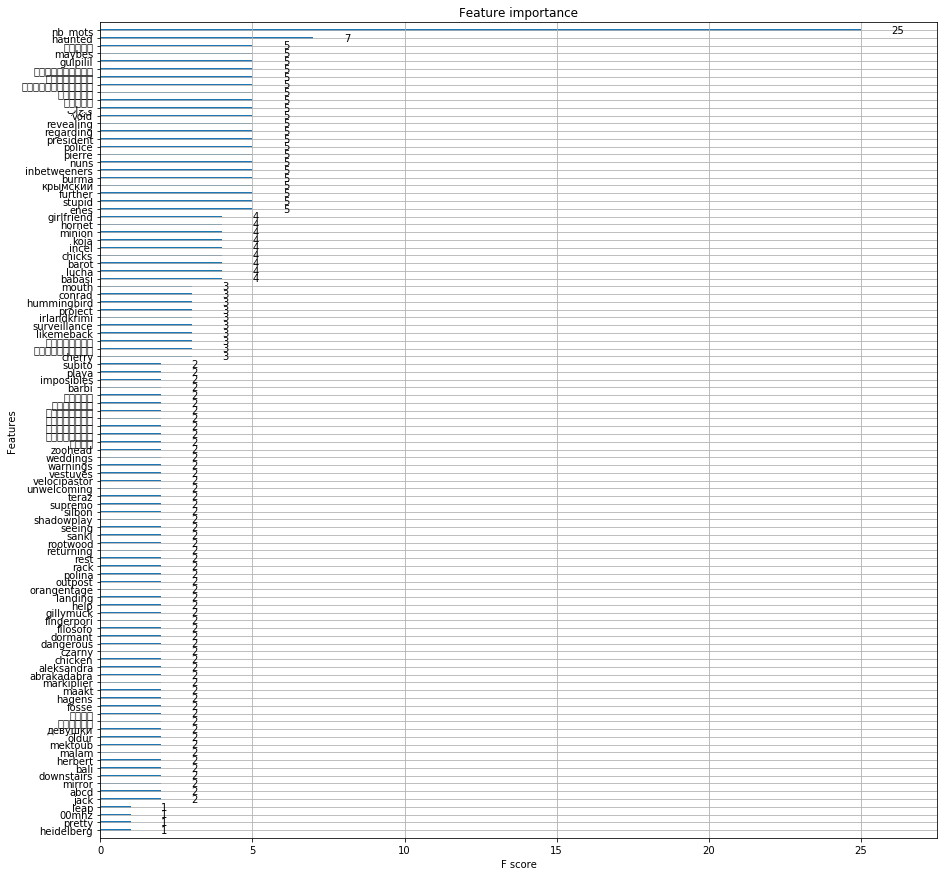

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
xgb.plot_importance(model, ax = ax);

## Affichage d'un des arbres

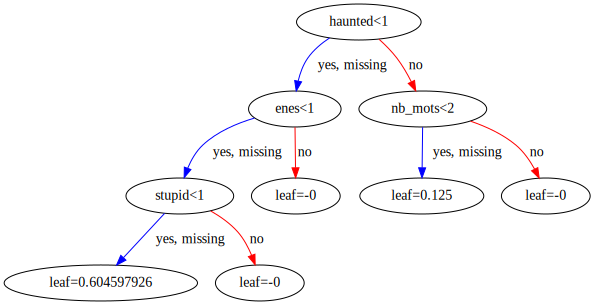

In [80]:
xgb.to_graphviz(model, num_trees=0)

# Evaluation sur l'ensemble de validation 

## Sur ensemble d'entraînement

In [18]:
Y_predict = model.predict(X_train)
Y_predict

array([6.515482 , 6.515482 , 6.515482 , ..., 6.515482 , 6.515482 ,
       6.5577383], dtype=float32)

In [21]:
print('MAE : ', round(metrics.mean_absolute_error(Y_train, Y_predict)))

MAE :  1.0


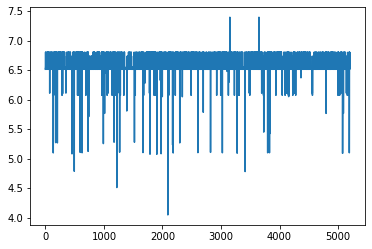

In [19]:
plt.plot(Y_predict);

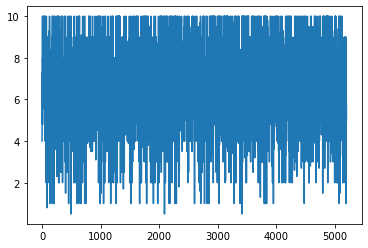

In [20]:
plt.plot(Y_train);

## Sur ensemble de validation

### Mise en forme de l'ensemble d'entraînement

In [135]:
for column in X_train.columns:
    x_val.insert(len(x_val.columns), column, 0)

x_val

,original_title,nb_mots,00mhz,1648,16th,18ാം,1938,1964,1980s,1985,...,scorsese,showdown,trek,джонни,hazin,jeffersons,seoul,воробьева,hikayesi,nine
id,,,,,,,,,,,,,,,,,,,,,
9110,Un amour impossible,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9597,Bernie the Dolphin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1862,The Last Whistle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1523,Cinayet Süsü,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537,All Rise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9366,Homegrown Christmas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6609,Apocalyptic 2077,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6102,The Dragon Unleashed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
word_number = 0
for index, row in x_val.iterrows():
    title = str(x_val.loc[index, 'original_title']).lower()
    title = title.translate(title.maketrans("","", string.punctuation))
    title_split = title.split()
    i = 1
    for word in title_split:
        if len(word) >= 4:
            if word in x_val.columns:
                x_val.loc[index, word] = 1
            i += 1
    
    X_train.loc[index, 'nb_mots'] = i - 1

del x_val['original_title']
x_val

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,nb_mots,00mhz,1648,16th,18ാം,1938,1964,1980s,1985,2040,...,scorsese,showdown,trek,джонни,hazin,jeffersons,seoul,воробьева,hikayesi,nine
id,,,,,,,,,,,,,,,,,,,,,
9110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Prédictions

In [24]:
y_predict = model.predict(x_val)

In [27]:
print('MAE : ', round(metrics.mean_absolute_error(y_val, y_predict)))

MAE :  1.0


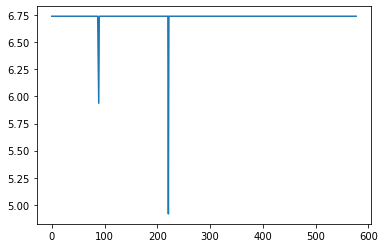

In [25]:
plt.plot(y_predict);

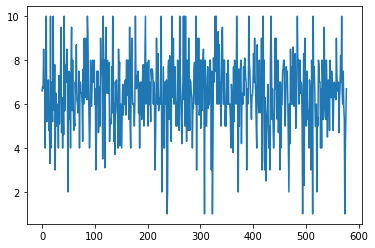

In [26]:
plt.plot(y_val);